 for improvements:

Consider only a single experiment - one could attribute some of these differences to multiple comparisons. How can we clearly delineate this?

`This might sound familiar to you if you have heard about “multiple testing”. Admittedly, we are testing multiple hypotheses and instead of using the standard p-value threshold 0.05 (somewhat arbitrary as well), we can adjust it intelligently to control for the inflated false discovery rate or family-wise error rate.`

Does this help me explain this bias better?

`For one single selected experiment, the observed result in the A/B test is expected to overstate its true effect. Usually we know that the sample mean is an unbiased estimate for the population mean. However, because one becomes interested in this particular experiment after observing that it is significantly positive, we are actually looking at an estimation conditional on that this experiment has been selected, or its observation exceeds a given threshold, hence upward bias has been introduced.`

Might be an interesting way to wrap this up

`Consider other ways to obtain more accurate measurements. For example, setting up a global holdout has been an effective way for us to achieve better estimation, not only to mitigate selection bias, but also to address other factors like seasonality, long-term versus short-term effects etc. Similarly, with the benefit of more data, one could also set up a new experiment just testing the selected features as a bundle to get an accurate measurement free of selection bias. In reality, we don’t conduct this often as it requires extra engineering work and slows down product development.`

### Winner's Curse

**Winner's curse** or **the statistical significance filter** tells us that any statistically significant results are positively biased. Why? For a result to be significant, its test statistic must exceed some critical value.
- If the observed value is less than the true value and less than the associated test statistic's critical value, the result will not be statistically significant.
- If the observed value is greater than the true value as well as the relevant critical value, then the result is significant.

This assymetry leads to a positive bias when estimating the true effect.

In this blog post, I simulate the effect of winner's bias with the aim of replicating the results presented in [AirBnB's Blog Post](https://medium.com/airbnb-engineering/selection-bias-in-online-experimentation-c3d67795cceb). I consider a program of experiments and compute the net benefit delivered by this experimentation program by summing the total observed effects. I compare the total observed effects to the total true effects, and by doing this demonstrate the positive bias effect of the winner's curse.

In [1]:
import numpy as np
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

### Create a class for a single experiment. 

Instantiate each experiment with a true treatment effect, a standard deviation and a sample size. We then draw observations from a normal distribution and compute the observed effect, which we'll compare against the true effect.

I define an additional method, `is_significant`, which computes a one sample t-test.

In [2]:
class Experiment:
    def __init__(self, true_effect, sd, n):
        self.true_effect = true_effect
        self.sd = sd
        self.n = n # sample size
        
        observations = stats.norm.rvs(true_effect, sd, n)
        self.observed_effect = np.average(observations)
        
    def is_significant(self):
        # one sample t-test. Null hypothesis is no true effect
        # alpha value of 0.05 has t_crit of 1.96 for two-sided t-test
        se = self.sd / np.sqrt(self.n)
        return True if self.observed_effect / se > 1.96 else False

### Simulate a number of experiments

The true effect and standard deviation values are drawn from the normal and inverse gamma, respectively, as outlined in [AirBnB's Blog Post](https://medium.com/airbnb-engineering/selection-bias-in-online-experimentation-c3d67795cceb). 

`n_experiments` are simulated each with a sample size `n`. For the collection of experiments I compute the `total true effect`, and the `total observed effect` (computed from summing the total observed effects of statistically significant experiments).

In [3]:
def simulate_experimental_program(n_experiments, n):  
    tes = stats.norm(loc=.2, scale=.2).rvs(size=n_experiments)   # true effects
    sds = stats.invgamma(a=3, scale=1).rvs(size=n_experiments)   # standard deviations

    experiments = [Experiment(true_effect=te, sd=sd, n=n) for te, sd in zip(tes, sds)]
    
    significant = [e for e in experiments if e.is_significant()]
    total_true_effect = np.sum([s.true_effect for s in significant])
    total_observed_effect = np.sum([s.observed_effect for s in significant])
    
    return total_true_effect, total_observed_effect

The function `simulate_experimental_program` defines one possible experimental program. Let's run a number of simulations.

In [6]:
def simulate_programs(n_simulations, n_experiments, n):
    total_true_effects = []
    total_observed_effects = []
    for _ in range(n_simulations):
        total_true_effect, total_observed_effect = simulate_experimental_program(n_experiments, n)
        total_true_effects.append(total_true_effect)
        total_observed_effects.append(total_observed_effect)
    return total_true_effects, total_observed_effects

### Simulate results for a single sample size

In [7]:
total_true_effects, total_observed_effects = simulate_programs(
    n_simulations=1000,
    n_experiments=30,
    n=10
)

df_single_n = pd.DataFrame(index = total_true_effects, 
                  data = total_observed_effects,
                  columns = ['Bottoms-up Effect'])
df_single_n.index.name = 'True Effect'

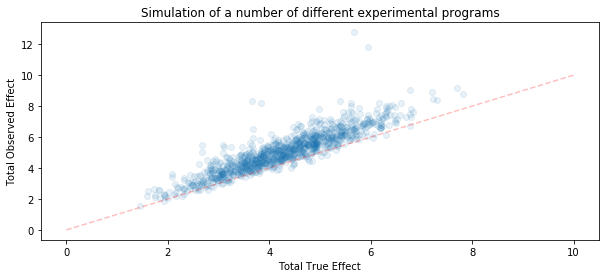

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
df_single_n.plot(style='o', alpha=0.1, ax=ax)

plt.ylabel('Total Observed Effect')
plt.xlabel('Total True Effect')
plt.title('Simulation of a number of different experimental programs')
ax.legend().set_visible(False)

# plot an y = x line
x = np.linspace(0, int(np.max(total_true_effects)), 100)
plt.plot(x,x, '--r', alpha=0.25);

The plot above shows, for simulated data, how summing up the total observed effect systematically overestimates the total true effect. This is why nearly all data points lie above the line `y = x`, plotted in light red.

Why do some points lie below the the `y = x` line? i.e. Why does the total observed effect underestimate the total true effect in some cases? Let's imagine a large-sized effect. Due to sampling variation and random error, we may only measure a medium-sized effect. This will still be a statistically significant difference, but an underestimate of the true effect size. This situation is comparatively rare resulting in the the overall bias being positive.

### Relationship to Statistical Power

Winner's curse describes a selection bias in which experimental results systematically overestimate the impact of a change. This bias is exacerbated for studies with low statistical power. Why?
- In underpowered studies, the estimate of our true effect will be more variable
- Only observed values with the biggest positive variance will pass the significance filter.

Using the sample size parameter `n` as a proxy for the statistical power, the following section demonstrates that the winner's curse problem is reduced for studies with high statistical power.

In [9]:
dataset = []

for n in [10, 50, 500]:
    total_true_effects, total_observed_effects = simulate_programs(
        n_simulations=1000,
        n_experiments=30,
        n=n
    )

    data = pd.DataFrame(index = total_true_effects, 
                        data = total_observed_effects,
                        columns = ['Bottoms-up Effect'])
    data.index.name = 'True Effect'
    data['Sample Size'] = n
    
    dataset.append(data)
    
df_multi_n = pd.concat(dataset)

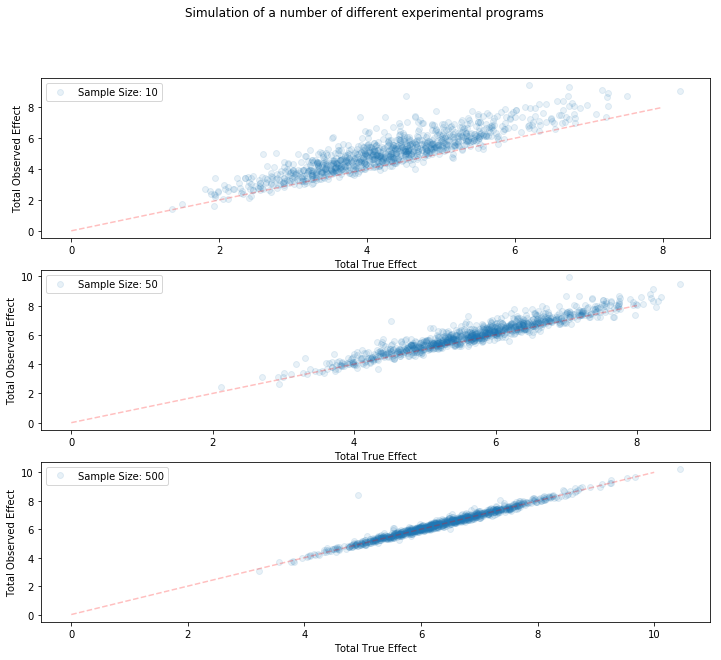

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(12,10))
for ax, sample_size in zip(axes, df_multi_n['Sample Size'].unique()):
    subset = df_multi_n[df_multi_n['Sample Size'] == sample_size]
    subset['Bottoms-up Effect'].plot(style='o', alpha=0.1, ax=ax)
    
    # plot an y = x line
    x = np.linspace(0, int(subset.index.max()), 100)
    ax.plot(x,x, '--r', alpha=0.25);
    
    ax.set_ylabel('Total Observed Effect')
    ax.set_xlabel('Total True Effect')
    ax.legend(['Sample Size: {}'.format(sample_size)])

plt.suptitle('Simulation of a number of different experimental programs');

The plot above demonstrates that as the sample size (and the statistical power) increases, the total observed effect's appoximation of the total true effect becomes closer and closer. This is because the winner's curse is less of a problem when the statistical power is high. 

### Conclusion

**Winner's curse** or the **statistical significance filter** causes the estimates of the uplift delivered by statistically significant results to be positively biased. In this blog post, I have demonstrated the effect of this bias through simulation, replicating AirBnB's post, and outlined the role that statistical power plays in reducing its effect.

Resources:
- [AirBnB's Blog Post](https://medium.com/airbnb-engineering/selection-bias-in-online-experimentation-c3d67795cceb) and accompanying [video](http://videolectures.net/kdd2018_lee_curse_estimation/)
- [Stack Overflow Question](https://stats.stackexchange.com/questions/176384/do-underpowered-studies-have-increased-likelihood-of-false-positives)
- A good summary of the [consequences of low-powered studies](https://www.nature.com/articles/nrn3475).